In [1]:
import re
import numpy as np
import string
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

In [2]:
#  Reads ‘alice.txt’ file
sample = open("alice.txt")
s = sample.read()
 
# Replaces escape character with space
sentences = s.replace("\n", " ")

In [3]:
import re 
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

In [4]:
words = sentences.split()
vocab = set(words)

In [5]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

In [6]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

In [7]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['start', 'of', 'project', 'gutenberg'], 'the'), (['of', 'the', 'gutenberg', 'ebook'], 'project'), (['the', 'project', 'ebook', 'alice'], 'gutenberg'), (['project', 'gutenberg', 'alice', 'adventures'], 'ebook'), (['gutenberg', 'ebook', 'adventures', 'in'], 'alice')]


In [8]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

In [9]:
def linear(m, theta):
    w = theta
    return m.dot(w)


def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())


def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)


def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]



def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o




def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw



def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

In [10]:
theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [11]:
epoch_losses = {}

for epoch in range(150):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Text(0, 0.5, 'Losses')

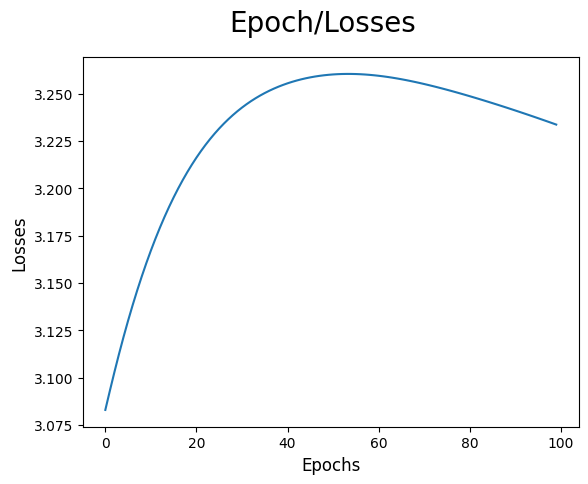

In [52]:
ix = np.arange(0,100)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

In [53]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [54]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['long','grass','her','feet'])

'she'